Calculate surface energy and water budgets from an ESM1.6 payu run

Takes ~ 10 minutes for a 30 year run. Runs ok in NCI small jupyterlab session

Creates plots in `/scratch/$PROJECT/$USER`
```
runname_energybal.png
runmame_waterbal.png
runmame_waterbal_aus.png
runmame_runoff.png
runmame_relative_waterbal.png (error / runoff)
```

In [7]:
import xarray as xr
import iris
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import datetime
import os
from pathlib import Path
import yaml
%matplotlib inline

In [8]:
archive = Path('/scratch/p66/jxs599/access-esm/archive/PI-case2d-expt-b23d18fc')

In [9]:
def savefig(name):
    # Saves plots to /scratch/$PROJECT/$USER
    # Adds a metadata string to aid in identifying plots
    basepath = Path('/scratch') / os.environ['PROJECT'] / os.environ['USER']
    path = basepath / name
    date = datetime.datetime.today().strftime("%Y-%m-%d %H:%M")
    plt.savefig(path, dpi=150, bbox_inches='tight',
        metadata={"History": (f"{name} created by esm16_energy_water_balance.ipynb at "
                              f"{date}")})

def annual_mean(ds):
    """ Properly month length weighted annual mean of a DataArray"""
    if not ds.time.dt.month[0] == 1:
        raise ValueError("Data does not start with January")
    if not ds.time.dt.month[1] == 2:
        raise ValueError("Non-monthly data")
    # Process only complete years
    nmon = 12*(len(ds.time)//12)
    month_length = ds.time.dt.days_in_month[:nmon]
    # Eventually use weighted ??? https://github.com/pydata/xarray/issues/3937
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    ann_mean = (ds[:nmon]*weights).groupby('time.year').sum(dim='time',min_count=1)
    return ann_mean

In [10]:
esm15_picontrol = Path('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1')

area = xr.open_dataset(esm15_picontrol / 'fx/areacella/gn/latest/areacella_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc').areacella

sftlf =  xr.open_dataset(esm15_picontrol / 'fx/sftlf/gn/latest/sftlf_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc').sftlf
land = xr.where(sftlf >= 100., 0, np.nan)

landCoverFrac = xr.open_dataset(esm15_picontrol / 'Lmon/landCoverFrac/gn/latest/landCoverFrac_Lmon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc', use_cftime=True).landCoverFrac[0]

lakes = xr.where(landCoverFrac[15] > 0, np.nan, 0)
ice = xr.where(landCoverFrac[16] > 0, np.nan, 0)

mask = land + lakes + ice

In [11]:
# Restricting it to just the required fields is much faster and also avoids problems
# with multiple time axes.
# Still takes ~ 4 minutes for 30 years
reqd = ['fld_s05i216', # precip
        'fld_s03i223', # evap
        'fld_s08i234', 'fld_s08i235',  # runoff
        'fld_s01i201', # rss
        'fld_s02i201', # rls
        'fld_s03i217', # hfss
        'fld_s03i234', # hfls
        'fld_s03i258',  # snm
        'time_bnds', 'lon_bnds', 'lat_bnds'
]

def _preprocess(d):
    return xr.Dataset({v:d[v] for v in reqd})

# Older version of payu used NetCDF rather than netCDF in path, so match both
d = xr.open_mfdataset(archive.glob(f'output*/atmosphere/[nN]etCDF/aiihca.pa*.nc'), combine='by_coords', use_cftime=True, preprocess=_preprocess)

In [12]:
rls = d['fld_s02i201']
rss = d['fld_s01i201']
hfss = d['fld_s03i217']
hfls = d['fld_s03i234']
snm = d['fld_s03i258']

net_energy = (rss + rls - hfss - hfls - snm)
net_energy_mean = annual_mean(net_energy).mean('year').load()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


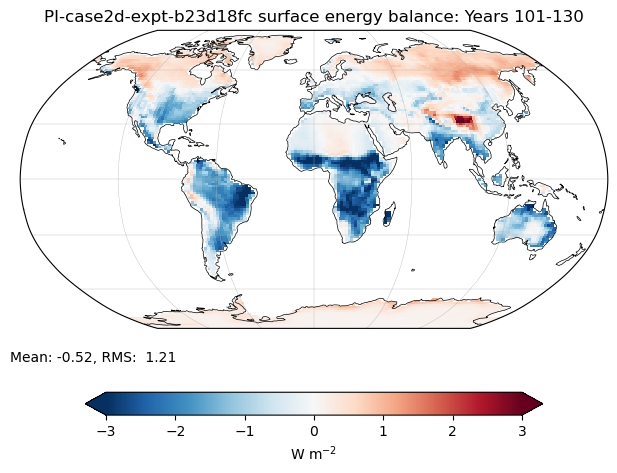

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
ax.coastlines(resolution='110m',linewidth=0.5)
ax.gridlines(draw_labels=False,linewidth=0.25)
diff = net_energy_mean + land
p = diff.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, vmax=3)
plt.colorbar(p, shrink=0.75, orientation='horizontal', extend='both', label='W m$^{-2}$')
y1 = net_energy.time.data[0].year
y2 = net_energy.time.data[-1].year
ax.set_title(f'{archive.name} surface energy balance: Years {y1}-{y2}')
mean = (diff*area).sum() / (area+land).sum()
rms = ((diff*diff*area).sum() / (area+land).sum())**0.5
mean = float(mean.data)
rms = float(rms.data)
fig.text(0.025, 0.25, f"Mean: {mean:5.2f}, RMS: {rms:5.2f}")
plt.tight_layout()
savefig(f'{archive.name}_energybal.png')


In [ ]:
pr = d['fld_s05i216']
evspsbl  = d['fld_s03i223']
runoff = d['fld_s08i234'] + d['fld_s08i235']

net_water = (pr - evspsbl - runoff)
net_water_mean = annual_mean(net_water).mean('year').load()

runoff_mean = annual_mean(runoff).mean('year').load()

INFO:flox:Entering _validate_reindex: reindex is None


INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:f

In [19]:
# Get the path to the initial restart from the configuration
config_fname = archive / 'output000/config.yaml'
with open(config_fname, 'r') as config_file:
    config = yaml.safe_load(config_file)

initial_restart = Path(config['restart']) / 'atmosphere/restart_dump.astart'

# At the moment the netCDF post-processing doesn't run for the last year, so
# calculate the appropriate final restart
ny = len(pr) // 12
# Here assuming running in 1 year chunks
final_restart = archive / f'restart{(ny-1):03d}/atmosphere/restart_dump.astart'

In [ ]:
# Get initial and final water content from the restart files

# The non-instantaneous fields in ESM1-5 restarts can loading problems so
# skip them with a callback. This is also faster
def instantaneous_callback(cube, field, filename):
    # Non-instantaneous fields have a cell_methods attribute which describes the
    # time processing.
    if cube.cell_methods:
        raise iris.exceptions.IgnoreCubeException

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="The stash code")
    mrsol0 = iris.load_cube(initial_restart, callback=instantaneous_callback,
                    constraint=iris.AttributeConstraint(STASH='m01s00i009'))
    snow0 = iris.load_cube(initial_restart, callback=instantaneous_callback,
                    constraint=iris.AttributeConstraint(STASH='m01s00i023'))
    mrsol1 = iris.load_cube(final_restart, callback=instantaneous_callback,
                    constraint=iris.AttributeConstraint(STASH='m01s00i009'))
    snow1 = iris.load_cube(final_restart, callback=instantaneous_callback,
                    constraint=iris.AttributeConstraint(STASH='m01s00i023'))
mtot0 = xr.DataArray.from_iris(mrsol0).sum('soil_model_level_number').rename({'latitude':'lat', 'longitude':'lon'})
mtot1 = xr.DataArray.from_iris(mrsol1).sum('soil_model_level_number').rename({'latitude':'lat', 'longitude':'lon'})
snow0 = xr.DataArray.from_iris(snow0).rename({'latitude':'lat', 'longitude':'lon'})
snow1 = xr.DataArray.from_iris(snow1).rename({'latitude':'lat', 'longitude':'lon'})

# Need to load to avoid getting a size zero array?
tmp = d.time_bnds.load()
t1 = tmp.data[0,0]  # Start time
t2 = tmp.data[-1,1] # End time
ndays = (t2 - t1).days
# Change to kg/m^2/s to match net_water
delta_water = (mtot1 + snow1 - mtot0 - snow0)/(86400*ndays)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_da

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:657: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


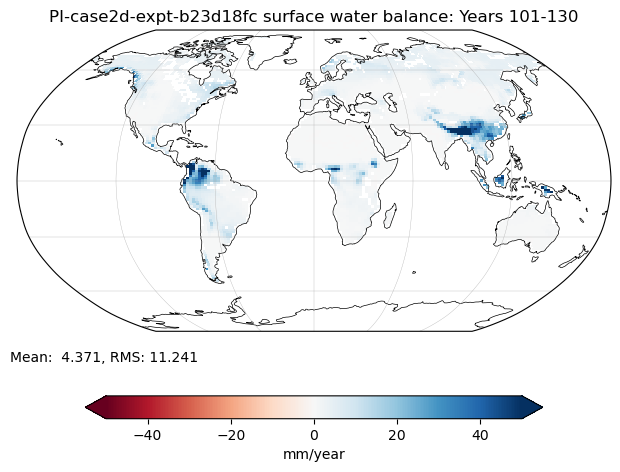

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
ax.coastlines(resolution='110m',linewidth=0.5)
ax.gridlines(draw_labels=False,linewidth=0.25)
# Convert to mm/year
diff = 365*86400*(net_water_mean - delta_water) + mask
p = diff.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu', vmax=50)
plt.colorbar(p, shrink=0.75, orientation='horizontal', extend='both', label='mm/year')
y1 = net_water.time.data[0].year
y2 = net_water.time.data[-1].year
ax.set_title(f'{archive.name} surface water balance: Years {y1}-{y2}')
mean = (diff*area).sum() / (area+mask).sum()
rms = ((diff*diff*area).sum() / (area+mask).sum())**0.5
mean = float(mean.data)
rms = float(rms.data)
fig.text(0.025, 0.25, f"Mean: {mean:6.3f}, RMS: {rms:6.3f}")
plt.tight_layout()
savefig(f'{archive.name}_waterbal.png')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:657: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


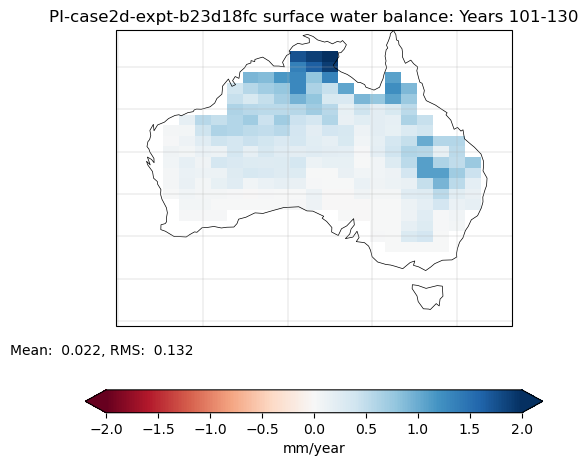

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m',linewidth=0.5)
ax.gridlines(draw_labels=False,linewidth=0.25)
# Convert to mm/year
diff = (365*86400*(net_water_mean - delta_water) + mask)[36:64,59:84]
p = diff.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu', vmax=2)
plt.colorbar(p, shrink=0.75, orientation='horizontal', extend='both', label='mm/year')
y1 = net_water.time.data[0].year
y2 = net_water.time.data[-1].year
ax.set_title(f'{archive.name} surface water balance: Years {y1}-{y2}')
mean = (diff*area).sum() / (area+mask).sum()
rms = ((diff*diff*area).sum() / (area+mask).sum())**0.5
mean = float(mean.data)
rms = float(rms.data)
fig.text(0.025, 0.25, f"Mean: {mean:6.3f}, RMS: {rms:6.3f}")
plt.tight_layout()
savefig(f'{archive.name}_waterbal_aus.png')


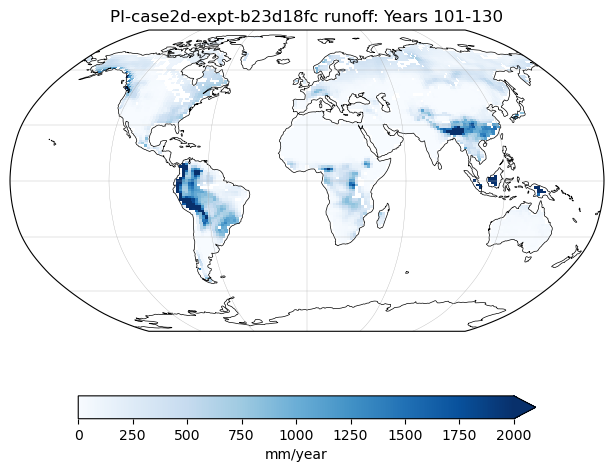

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
ax.coastlines(resolution='110m',linewidth=0.5)
ax.gridlines(draw_labels=False,linewidth=0.25)
p = (86400*365*runoff_mean + mask).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Blues', vmax=2000)
plt.colorbar(p, shrink=0.75, orientation='horizontal', extend='max', label='mm/year')
ax.set_title('')
ax.set_title(f'{archive.name} runoff: Years {y1}-{y2}')
plt.tight_layout()
savefig(f'{archive.name}_runoff.png')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:657: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


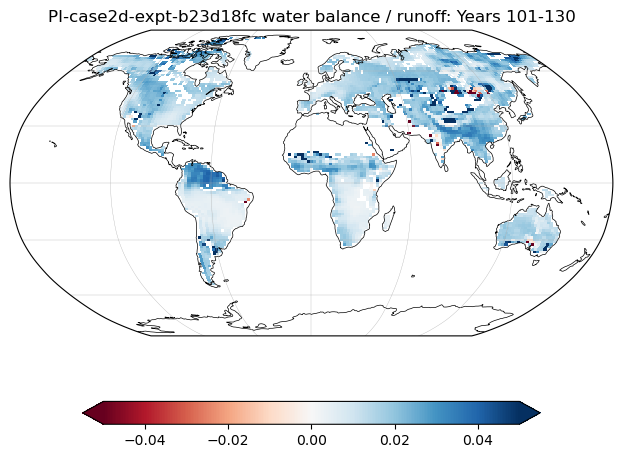

In [24]:
# runoff_mean = annual_mean(runoff).mean('year').load()
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
ax.coastlines(resolution='110m',linewidth=0.5)
ax.gridlines(draw_labels=False,linewidth=0.25)
relative_diff = ((net_water_mean - delta_water)  / runoff_mean + mask)
p = relative_diff.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu', vmax=0.05)
plt.colorbar(p, shrink=0.75, orientation='horizontal', extend='both')
ax.set_title(f'{archive.name} water balance / runoff: Years {y1}-{y2}')
plt.tight_layout()
savefig(f'{archive.name}_relative_waterbal.png')
